In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import os


In [66]:
#load dataset
df = pd.read_excel('../data/Dataset_2020-2024.xlsx')



--- Info Awal Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TANGGAL  1814 non-null   object
 1   TN       1814 non-null   object
 2   TX       1814 non-null   object
 3   TAVG     1814 non-null   object
 4   RH_AVG   1814 non-null   object
 5   RR       1814 non-null   object
 6   SS       1814 non-null   object
 7   FF_X     1814 non-null   int64 
 8   DDD_X    1814 non-null   int64 
 9   FF_AVG   1814 non-null   int64 
 10  DDD_CAR  1814 non-null   object
dtypes: int64(3), object(8)
memory usage: 156.0+ KB

--- Statistik Deskriptif ---
           TANGGAL    TN      TX    TAVG  RH_AVG    RR      SS         FF_X  \
count         1814  1814  1814.0  1814.0  1814.0  1814  1814.0  1814.000000   
unique        1811    63    78.0    62.0    27.0   387   111.0          NaN   
top     18-09-2021     -    32.0    27.9    84.0     -     8.0    

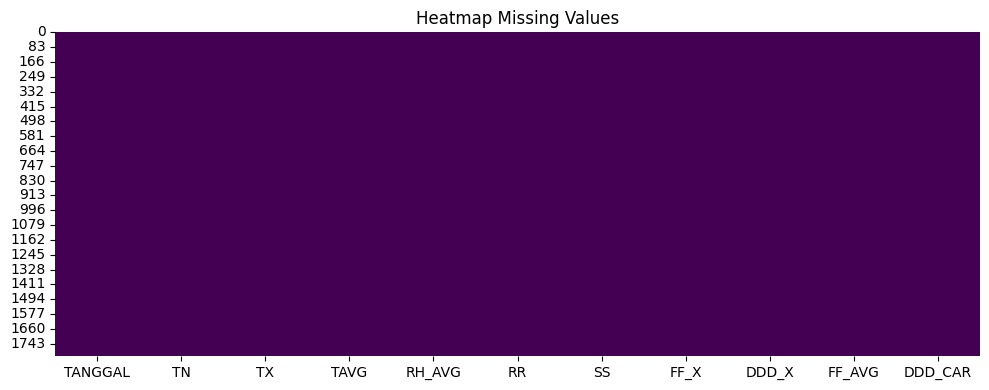

In [67]:
print("\n--- Info Awal Dataset ---")
df.info()

print("\n--- Statistik Deskriptif ---")
print(df.describe(include='all'))

print("\n--- Missing Value per Kolom ---")
print(df.isnull().sum())

# === Visualisasi Missing Value
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap Missing Values')
plt.tight_layout()
plt.show()



In [68]:
# missing value handling
df = df.replace(['8888', '9999', '-', 8888, 9999], np.nan).infer_objects()
numeric_columns = ['TN', 'TX', 'TAVG', 'RH_AVG', 'RR', 'SS']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

C:\Users\HP\AppData\Local\Temp\ipykernel_17752\4087331000.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['8888', '9999', '-', 8888, 9999], np.nan).infer_objects()


In [69]:
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')
df = df.sort_values(by='TANGGAL').reset_index(drop=True)


In [70]:
imputer = SimpleImputer(strategy='median')
columns_to_impute = df.select_dtypes(include=np.number).columns.tolist()
if 'TANGGAL' in columns_to_impute:
    columns_to_impute.remove('TANGGAL')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [71]:
# === Feature Engineering ===
df['RR_lag1'] = df['RR'].shift(1)
df['TAVG_lag1'] = df['TAVG'].shift(1)
df['RH_AVG_lag1'] = df['RH_AVG'].shift(1)
df['SS_lag1'] = df['SS'].shift(1)
df['TX_lag1'] = df['TX'].shift(1)
df['TN_lag1'] = df['TN'].shift(1)
df['RR_rolling_mean_3d_lag1'] = df['RR'].rolling(window=3, min_periods=1).mean().shift(1)

df_preprocessed_full = df.copy()
df.dropna(inplace=True)

In [72]:
#kategorisasi target
def rr_categorization(rr):
    if rr == 0:
        return 'No Rain'
    elif rr <= 20:
        return 'Hujan Ringan'
    elif rr <= 50:
        return 'Hujan Sedang'
    elif rr <= 100:
        return 'Hujan Lebat'
    else:
        return 'Hujan Sangat Lebat'

df['RR_KAT'] = df['RR'].apply(rr_categorization)

In [73]:
#encoding 
le = LabelEncoder()
df['RR_KAT_ENC'] = le.fit_transform(df['RR_KAT'])


In [74]:
#feature engineering
feature_columns = [
    'TN', 'TX', 'TAVG', 'RH_AVG', 'SS',
    'RR_lag1', 'TAVG_lag1', 'RH_AVG_lag1',
    'SS_lag1', 'TX_lag1', 'TN_lag1',
    'RR_rolling_mean_3d_lag1'
]
X = df[feature_columns]
y = df['RR_KAT_ENC']

In [75]:
#standarisasi 
scaler= StandardScaler()
X_scaled = scaler.fit_transform(X)

In [76]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [77]:
# === SMOTE hanya di training ===
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [78]:
# === Training Model Default ===
nb_model = GaussianNB().fit(X_train_bal, y_train_bal)
knn_model = KNeighborsClassifier(n_neighbors=7).fit(X_train_bal, y_train_bal)
rf_model = RandomForestClassifier(random_state=42).fit(X_train_bal, y_train_bal)



--- Evaluasi Model Default ---

=== Naive Bayes ===
Akurasi: 0.2534435261707989
                    precision    recall  f1-score   support

       Hujan Lebat       0.03      0.07      0.04        14
      Hujan Ringan       0.77      0.11      0.19       249
Hujan Sangat Lebat       0.12      1.00      0.22         4
      Hujan Sedang       0.16      0.31      0.21        36
           No Rain       0.26      0.82      0.39        60

          accuracy                           0.25       363
         macro avg       0.27      0.46      0.21       363
      weighted avg       0.59      0.25      0.22       363


=== KNN ===
Akurasi: 0.371900826446281
                    precision    recall  f1-score   support

       Hujan Lebat       0.09      0.29      0.13        14
      Hujan Ringan       0.73      0.30      0.42       249
Hujan Sangat Lebat       0.13      0.50      0.21         4
      Hujan Sedang       0.18      0.33      0.24        36
           No Rain       0.32      

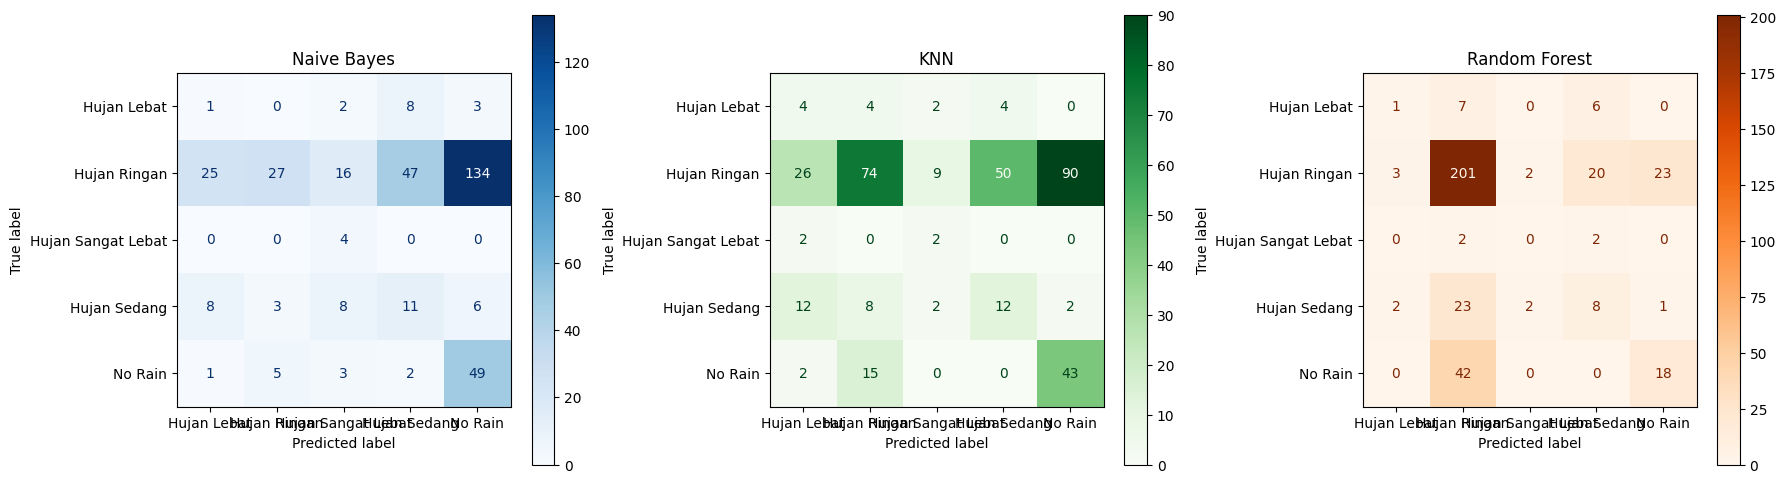

In [79]:
# === Evaluasi Model Default ===
print("\n--- Evaluasi Model Default ---")
for name, model in {
    'Naive Bayes': nb_model,
    'KNN': knn_model,
    'Random Forest': rf_model
}.items():
    y_pred = model.predict(X_test)
    print(f'\n=== {name} ===')
    print('Akurasi:', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# === Confusion Matrix ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test, display_labels=le.classes_, cmap='Blues', ax=axes[0])
axes[0].set_title('Naive Bayes')
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test, display_labels=le.classes_, cmap='Greens', ax=axes[1])
axes[1].set_title('KNN')
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, display_labels=le.classes_, cmap='Oranges', ax=axes[2])
axes[2].set_title('Random Forest')
plt.tight_layout()
plt.show()

In [80]:
# === Cross Validation Default ===
print("\n--- Cross Validation (Default Models) ---")
default_models = {
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}
for name, model in default_models.items():
    scores = cross_val_score(model, X_train_bal, y_train_bal, cv=5, scoring='accuracy')
    print(f"{name} → CV Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")



--- Cross Validation (Default Models) ---
GaussianNB → CV Mean: 0.4504, Std: 0.0090
KNN → CV Mean: 0.8450, Std: 0.0080
Random Forest → CV Mean: 0.9201, Std: 0.0241


In [81]:
from sklearn.model_selection import cross_validate

print("\n--- Cross Validation (Default Models + Multi Metrics) ---")

default_models = {
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for name, model in default_models.items():
    results = cross_validate(model, X_train_bal, y_train_bal,
                             cv=5, scoring=scoring_metrics, return_train_score=False)
    
    print(f"\n=== {name} ===")
    print(f"Accuracy  : {results['test_accuracy'].mean():.4f} ± {results['test_accuracy'].std():.4f}")
    print(f"Precision : {results['test_precision_macro'].mean():.4f}")
    print(f"Recall    : {results['test_recall_macro'].mean():.4f}")
    print(f"F1-Score  : {results['test_f1_macro'].mean():.4f}")



--- Cross Validation (Default Models + Multi Metrics) ---

=== GaussianNB ===
Accuracy  : 0.4504 ± 0.0090
Precision : 0.4593
Recall    : 0.4504
F1-Score  : 0.4185

=== KNN ===
Accuracy  : 0.8450 ± 0.0080
Precision : 0.8559
Recall    : 0.8450
F1-Score  : 0.8170

=== Random Forest ===
Accuracy  : 0.9201 ± 0.0241
Precision : 0.9216
Recall    : 0.9201
F1-Score  : 0.9181


In [82]:
import pandas as pd
from sklearn.model_selection import cross_validate

# Model & scoring
default_models = {
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_folds = 5
all_cv_results = []

# Loop model
for name, model in default_models.items():
    results = cross_validate(model, X_train_bal, y_train_bal,
                             cv=cv_folds, scoring=scoring, return_train_score=False)
    
    for i in range(cv_folds):
        all_cv_results.append({
            'Model': name,
            'Fold': i + 1,
            'Accuracy': results['test_accuracy'][i],
            'Precision': results['test_precision_macro'][i],
            'Recall': results['test_recall_macro'][i],
            'F1 Score': results['test_f1_macro'][i]
        })

# Buat DataFrame
df_cv_results = pd.DataFrame(all_cv_results)

# Tampilkan
print("\n=== Tabel Hasil Cross Validation Per Fold ===")
print(df_cv_results.round(4))



=== Tabel Hasil Cross Validation Per Fold ===
            Model  Fold  Accuracy  Precision  Recall  F1 Score
0      GaussianNB     1    0.4357     0.4273  0.4358    0.4025
1      GaussianNB     2    0.4508     0.4489  0.4511    0.4192
2      GaussianNB     3    0.4488     0.4746  0.4484    0.4158
3      GaussianNB     4    0.4528     0.4613  0.4529    0.4217
4      GaussianNB     5    0.4639     0.4845  0.4638    0.4333
5             KNN     1    0.8303     0.8372  0.8302    0.8008
6             KNN     2    0.8544     0.8606  0.8549    0.8301
7             KNN     3    0.8484     0.8688  0.8483    0.8174
8             KNN     4    0.8444     0.8542  0.8442    0.8124
9             KNN     5    0.8474     0.8590  0.8472    0.8244
10  Random Forest     1    0.8735     0.8734  0.8734    0.8728
11  Random Forest     2    0.9227     0.9209  0.9229    0.9210
12  Random Forest     3    0.9297     0.9331  0.9297    0.9271
13  Random Forest     4    0.9418     0.9447  0.9417    0.9396
14  Rand

In [83]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
import pandas as pd

# === Definisikan Model
default_models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# === 1. Evaluasi di Test Set (tanpa CV)
test_results = []
for name, model in default_models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    test_results.append({
        'Model': name,
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Test Recall': recall_score(y_test, y_pred, average='macro'),
        'Test F1 Score': f1_score(y_test, y_pred, average='macro')
    })
df_test_results = pd.DataFrame(test_results).round(4)

# === 2. Evaluasi Cross-Validation di Train (5-Fold CV)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results = []
for name, model in default_models.items():
    scores = cross_validate(model, X_train_bal, y_train_bal, cv=5, scoring=scoring)
    cv_results.append({
        'Model': name,
        'CV Accuracy': scores['test_accuracy'].mean(),
        'CV Precision': scores['test_precision_macro'].mean(),
        'CV Recall': scores['test_recall_macro'].mean(),
        'CV F1 Score': scores['test_f1_macro'].mean()
    })
df_cv_results = pd.DataFrame(cv_results).round(4)

# === Gabungkan Tabel
df_compare = pd.merge(df_test_results, df_cv_results, on='Model')
print("\n=== Perbandingan Evaluasi: Test vs Cross-Validation ===")
print(df_compare)



=== Perbandingan Evaluasi: Test vs Cross-Validation ===
           Model  Test Accuracy  Test Precision  Test Recall  Test F1 Score  \
0    Naive Bayes         0.2534          0.2676       0.4604         0.2095   
1            KNN         0.3884          0.2923       0.4165         0.2986   
2  Random Forest         0.6281          0.3097       0.2802         0.2885   

   CV Accuracy  CV Precision  CV Recall  CV F1 Score  
0       0.4504        0.4593     0.4504       0.4185  
1       0.8450        0.8559     0.8450       0.8170  
2       0.9201        0.9216     0.9201       0.9181  


In [84]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_scores = cross_validate(rf_best, X_train_bal, y_train_bal, scoring=scoring, cv=skf)

print("\n=== Cross Validation (Tuned Random Forest) ===")
for s in scoring:
    print(f"{s}: {cv_scores[f'test_{s}'].mean():.4f} ± {cv_scores[f'test_{s}'].std():.4f}")



=== Cross Validation (Tuned Random Forest) ===
accuracy: 0.9187 ± 0.0056
precision_macro: 0.9176 ± 0.0054
recall_macro: 0.9187 ± 0.0057
f1_macro: 0.9167 ± 0.0059


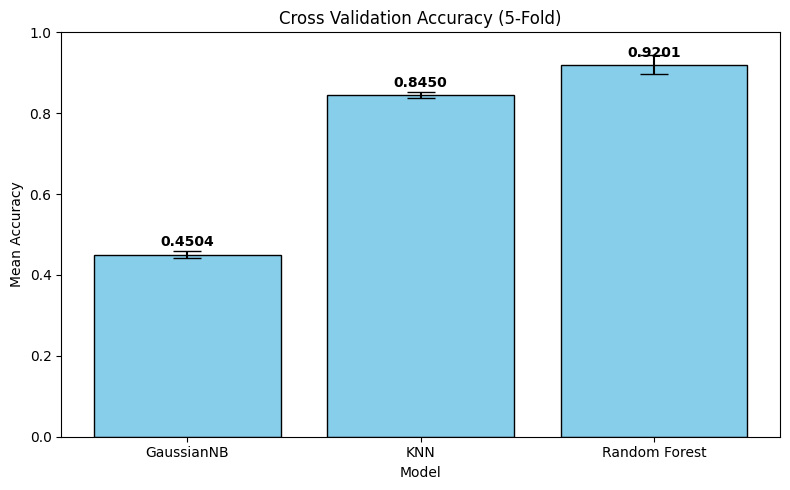

In [85]:
model_names = ['GaussianNB', 'KNN', 'Random Forest']
cv_means = [0.4504, 0.8450, 0.9201]
cv_stds = [0.0090, 0.0080, 0.0241]

x = np.arange(len(model_names))
width = 0.6

plt.figure(figsize=(8, 5))
plt.bar(x, cv_means, yerr=cv_stds, capsize=10, color='skyblue', edgecolor='black')
plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.title('Cross Validation Accuracy (5-Fold)')
plt.ylabel('Mean Accuracy')
plt.xlabel('Model')

for i, v in enumerate(cv_means):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [86]:
n_future_days = 7  # Ubah ke 5 jika hanya ingin 5 hari
print(f"\n--- Prediksi {n_future_days} Hari ke Depan ---")

future_preds = []
last_row = df_preprocessed_full.iloc[-1]
last_date = last_row['TANGGAL']
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, n_future_days + 1)]
avg7 = df_preprocessed_full[numeric_columns].iloc[-7:].mean()

for i, date in enumerate(future_dates):
    f = {
        'TN': avg7['TN'], 'TX': avg7['TX'], 'TAVG': avg7['TAVG'],
        'RH_AVG': avg7['RH_AVG'], 'RR': avg7['RR'], 'SS': avg7['SS']
    }

    if i == 0:
        f.update({
            'RR_lag1': last_row['RR'], 'TAVG_lag1': last_row['TAVG'], 'RH_AVG_lag1': last_row['RH_AVG'],
            'SS_lag1': last_row['SS'], 'TX_lag1': last_row['TX'], 'TN_lag1': last_row['TN'],
            'RR_rolling_mean_3d_lag1': df_preprocessed_full['RR'].iloc[-3:].mean()
        })
    else:
        f.update({
            'RR_lag1': avg7['RR'], 'TAVG_lag1': avg7['TAVG'], 'RH_AVG_lag1': avg7['RH_AVG'],
            'SS_lag1': avg7['SS'], 'TX_lag1': avg7['TX'], 'TN_lag1': avg7['TN'],
            'RR_rolling_mean_3d_lag1': avg7['RR']
        })

    row = pd.DataFrame([f])[feature_columns]
    scaled_row = scaler.transform(row)

    future_preds.append({
        'Tanggal': date.strftime('%Y-%m-%d'),
        'Naive Bayes': le.inverse_transform([nb_best.predict(scaled_row)[0]])[0],
        'KNN': le.inverse_transform([knn_best.predict(scaled_row)[0]])[0],
        'Random Forest': le.inverse_transform([rf_best.predict(scaled_row)[0]])[0]
    })

df_prediksi = pd.DataFrame(future_preds)
print(df_prediksi)
 


--- Prediksi 7 Hari ke Depan ---
      Tanggal   Naive Bayes      KNN Random Forest
0  2025-01-01       No Rain  No Rain  Hujan Ringan
1  2025-01-02  Hujan Sedang  No Rain       No Rain
2  2025-01-03  Hujan Sedang  No Rain       No Rain
3  2025-01-04  Hujan Sedang  No Rain       No Rain
4  2025-01-05  Hujan Sedang  No Rain       No Rain
5  2025-01-06  Hujan Sedang  No Rain       No Rain
6  2025-01-07  Hujan Sedang  No Rain       No Rain


In [87]:
def predict_from_input(last_data: dict, n_days=5):
    future_preds = []
    avg7 = df_preprocessed_full[numeric_columns].iloc[-7:].mean()
    last_date = last_data['TANGGAL']
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, n_days + 1)]

    for i, tgl in enumerate(future_dates):
        f = {
            'TN': avg7['TN'], 'TX': avg7['TX'], 'TAVG': avg7['TAVG'],
            'RH_AVG': avg7['RH_AVG'], 'RR': avg7['RR'], 'SS': avg7['SS']
        }

        if i == 0:
            f.update({
                'RR_lag1': last_data['RR'], 'TAVG_lag1': last_data['TAVG'], 'RH_AVG_lag1': last_data['RH_AVG'],
                'SS_lag1': last_data['SS'], 'TX_lag1': last_data['TX'], 'TN_lag1': last_data['TN'],
                'RR_rolling_mean_3d_lag1': df_preprocessed_full['RR'].iloc[-3:].mean()
            })
        else:
            f.update({
                'RR_lag1': avg7['RR'], 'TAVG_lag1': avg7['TAVG'], 'RH_AVG_lag1': avg7['RH_AVG'],
                'SS_lag1': avg7['SS'], 'TX_lag1': avg7['TX'], 'TN_lag1': avg7['TN'],
                'RR_rolling_mean_3d_lag1': avg7['RR']
            })

        row = pd.DataFrame([f])[feature_columns]
        scaled = scaler.transform(row)

        future_preds.append({
            'Tanggal': tgl.strftime('%Y-%m-%d'),
            'Naive Bayes': le.inverse_transform([nb_best.predict(scaled)[0]])[0],
            'KNN': le.inverse_transform([knn_best.predict(scaled)[0]])[0],
            'Random Forest': le.inverse_transform([rf_best.predict(scaled)[0]])[0]
        })

    return pd.DataFrame(future_preds)


In [88]:
# Input dari user (misalnya hari ini)
manual_input = {
    'TANGGAL': pd.Timestamp('2025-06-25'),
    'TN': 23.4,
    'TX': 32.1,
    'TAVG': 27.3,
    'RH_AVG': 81.2,
    'RR': 12.5,
    'SS': 6.0
}
pred_manual = predict_from_input(manual_input, n_days=7)
print(pred_manual)


      Tanggal   Naive Bayes      KNN Random Forest
0  2025-06-26  Hujan Ringan  No Rain       No Rain
1  2025-06-27  Hujan Sedang  No Rain       No Rain
2  2025-06-28  Hujan Sedang  No Rain       No Rain
3  2025-06-29  Hujan Sedang  No Rain       No Rain
4  2025-06-30  Hujan Sedang  No Rain       No Rain
5  2025-07-01  Hujan Sedang  No Rain       No Rain
6  2025-07-02  Hujan Sedang  No Rain       No Rain
